# Newyork  Neighborhoods Classified to move in or visit
##### by H.S.

### Importing packages

In [1]:
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
import matplotlib.pyplot as plt
import json 
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')





Libraries imported.


### Setting the credential for  Foursquare API 

In [2]:
CLIENT_ID = 'JY5IJTKN2WW0SIXRESXY1MVVDRKCCKIK2N53MDFQLOLPKXDC' # your Foursquare ID
CLIENT_SECRET = 'T03133FGDWILHUM1VDXBMZX5JF5GGCNDIELRGHNZBYCC211U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Import Newyork city  Neighborhood Name & Location Data 

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
nyc_neighborhood_data = newyork_data['features']
nyc_neighborhood_data[2]

{'type': 'Feature',
 'id': 'nyu_2451_34572.3',
 'geometry': {'type': 'Point',
  'coordinates': [-73.82780644716412, 40.887555677350775]},
 'geometry_name': 'geom',
 'properties': {'name': 'Eastchester',
  'stacked': 1,
  'annoline1': 'Eastchester',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.82780644716412,
   40.887555677350775,
   -73.82780644716412,
   40.887555677350775]}}

In [4]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhood_data:
    borough = nyc_neighborhood_data = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
nyc_neighborhoods.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Function To Create API Url

In [28]:
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            limit
        )
    return url

endpoint = 'https://api.foursquare.com/v2/venues/search?'
categoryIds = ['4bf58dd8d48988d1e5931735', '4bf58dd8d48988d1e7931735', '4bf58dd8d48988d1e8931735',
               '4bf58dd8d48988d1e9931735', '5032792091d4c4b30a586d5c', '56aa371be4b08b9a8d5734db',
               '5267e4d9e4b0ec79466e48d1', '4d4b7105d754a06376d81259', '4bf58dd8d48988d1fe941735',
               '4bf58dd8d48988d10d951735', '52f2ab2ebcbc57f1066b8b37',
              ]
categoryId = ','.join(categoryIds)
limit = 50

#### Function To Retrieve  Venues Per Neighborhood


In [30]:
def getNearbyMusicVenues(neighborhoods, latitudes, longitudes, radius=1000):
    endpoint = 'https://api.foursquare.com/v2/venues/search?'
    venues_list = []   
    
    for hood_name, lat, lng in zip(neighborhoods, latitudes, longitudes):
    
        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        
        results = requests.get(url).json()['response']['venues']

        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
            venue_state = item['location']['state']
            
            venues_list.append([(hood_name,
                                lat,
                                lng,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lng,
                                venue_city,
                                venue_state
                               )])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue Name',
                             'Venue Category',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue City',
                             'Venue State'
                            ]
    return nearby_venues

prelim_venue_data = getNearbyMusicVenues(nyc_neighborhoods['Neighborhood'],
                                         nyc_neighborhoods['Latitude'],
                                         nyc_neighborhoods['Longitude']
                                         
                                        )

#### Save As CSV To Avoid Further API Calls


In [31]:
prelim_venue_data.to_csv(path_or_buf='prelim_venue_data.csv')

#### Loading the previously saved DataFrame from csv

In [32]:
prelim_venue_data = pd.read_csv('prelim_venue_data.csv', index_col=0)
prelim_venue_data.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Wakefield,40.894705,-73.847201,The Upper Room,Music Venue,40.892567,-73.846406,NaN,New York
1,Wakefield,40.894705,-73.847201,241st Liquor Store,Other Nightlife,40.902771,-73.849898,Bronx,NY
2,Wakefield,40.894705,-73.847201,Dyme Life Radio,Music Venue,40.894541,-73.843266,Bronx,NY
3,Wakefield,40.894705,-73.847201,Par-City,Music Venue,40.890211,-73.847002,Bronx,NY
4,Wakefield,40.894705,-73.847201,Tavern,Bar,40.895898,-73.855731,Bronx,NY


### Data Analysis

#### What states are the venues in?

In [33]:
prelim_venue_data.groupby('Venue State')['Venue State'].count()

Venue State
MA             2
NJ            17
NY          8817
New York     617
Name: Venue State, dtype: int64

#### What venue categories are the entries in?

In [34]:
n_unique = len(prelim_venue_data['Venue Category'].unique())
print(f'There are {n_unique} unique venue categories in this dataframe')
prelim_venue_data.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 149 unique venue categories in this dataframe


Venue Category
Bar                                         2094
Lounge                                       929
Cocktail Bar                                 500
Nightclub                                    481
Other Nightlife                              476
Music Venue                                  470
Pub                                          341
Wine Bar                                     278
Sports Bar                                   264
Hookah Bar                                   243
Beer Garden                                  214
American Restaurant                          206
Dive Bar                                     200
Karaoke Bar                                  172
Concert Hall                                 133
Speakeasy                                    130
Music Store                                  122
Brewery                                      119
Nightlife Spot                               118
Hotel Bar                                    114
Recor

#### How many venues did not have the  'city' field 

In [35]:
n_unknown_cities = prelim_venue_data[prelim_venue_data['Venue City']=='N/A']['Venue Name'].count()
print(f'There were {n_unknown_cities} entries in the dataset without the "city" parameter filled-out')

There were 0 entries in the dataset without the "city" parameter filled-out


In [36]:
prelim_venue_data[prelim_venue_data['Venue City']=='N/A']['Venue Name'][0:5]

Series([], Name: Venue Name, dtype: object)

#### Are there any 'null' values in the dataset?

In [37]:
prelim_venue_data.isnull().values.any()

True

#### How many unique venues are there?

In [38]:
n_unique_venues = len(prelim_venue_data['Venue Name'].unique())
print(f'There are {n_unique_venues} unique venues in the preliminary dataset')

There are 5042 unique venues in the preliminary dataset


### Data Pre-Processing

#### Remove entries with "Venue State" not equal to "New York" or "NY"

In [39]:
ny_venue_data = prelim_venue_data[(prelim_venue_data['Venue State'] == "New York") | (prelim_venue_data['Venue State'] == "NY")]
ny_venue_data['Venue State'].replace(to_replace="New York", value="NY", inplace=True)
delta = prelim_venue_data.shape[0] - ny_venue_data.shape[0]
print(f'{delta} entries were removed from the preliminary dataset based on "Venue State"')
ny_venue_data.head(5)

19 entries were removed from the preliminary dataset based on "Venue State"


/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Wakefield,40.894705,-73.847201,The Upper Room,Music Venue,40.892567,-73.846406,NaN,NY
1,Wakefield,40.894705,-73.847201,241st Liquor Store,Other Nightlife,40.902771,-73.849898,Bronx,NY
2,Wakefield,40.894705,-73.847201,Dyme Life Radio,Music Venue,40.894541,-73.843266,Bronx,NY
3,Wakefield,40.894705,-73.847201,Par-City,Music Venue,40.890211,-73.847002,Bronx,NY
4,Wakefield,40.894705,-73.847201,Tavern,Bar,40.895898,-73.855731,Bronx,NY


In [46]:
categories=prelim_venue_data['Venue Category']
categories

0                                    Music Venue
1                                Other Nightlife
2                                    Music Venue
3                                    Music Venue
4                                            Bar
5                                    Music Venue
6                                    Music Venue
7                                Other Nightlife
8                                            Bar
9                                     Smoke Shop
10                                           Bar
11                                           Bar
12                                           Bar
13                                   Music Venue
14                                   Music Venue
15                                     Nightclub
16                                           Bar
17                                     Nightclub
18                                Nightlife Spot
19                                     Speakeasy
20                  

#### Remove entries with "Venue City" equal to "N/A"

In [40]:
ny_venue_data_with_city = ny_venue_data[(ny_venue_data['Venue City'] != "N/A")]
delta = ny_venue_data.shape[0] - ny_venue_data_with_city.shape[0]
print(f'{delta} entries were removed based on "Venue City"')
ny_venue_data_with_city.head(5)

0 entries were removed based on "Venue City"


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Wakefield,40.894705,-73.847201,The Upper Room,Music Venue,40.892567,-73.846406,NaN,NY
1,Wakefield,40.894705,-73.847201,241st Liquor Store,Other Nightlife,40.902771,-73.849898,Bronx,NY
2,Wakefield,40.894705,-73.847201,Dyme Life Radio,Music Venue,40.894541,-73.843266,Bronx,NY
3,Wakefield,40.894705,-73.847201,Par-City,Music Venue,40.890211,-73.847002,Bronx,NY
4,Wakefield,40.894705,-73.847201,Tavern,Bar,40.895898,-73.855731,Bronx,NY


#### One-Hot-Encode Venue Categories

In [42]:
ny_venue_category_onehot = pd.get_dummies(ny_venue_data[['Venue Category']], prefix="", prefix_sep="")

ny_venue_category_onehot['Neighborhood'] = ny_venue_data['Neighborhood'] 

fixed_columns = [ny_venue_category_onehot.columns[-1]] + list(ny_venue_category_onehot.columns[:-1])
ny_venue_category_onehot = ny_venue_category_onehot[fixed_columns]

print(ny_venue_category_onehot.shape)
ny_venue_category_onehot.head(10)

(9434, 150)


,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Brewery,Building,Burger Joint,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Cocktail Bar,Coffee Shop,College Residence Hall,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Coworking Space,Cuban Restaurant,Dance Studio,Diner,Distillery,Dive Bar,English Restaurant,Event Space,Fast Food Restaurant,Field,Food Court,Fraternity House,French Restaurant,Fried Chicken Joint,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gourmet Shop,Gym,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Museum,Music Festival,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Office,Opera House,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Pet Café,Piano Bar,Pizza Place,Pool Hall,Portuguese Restaurant,Professional & Other Places,Pub,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Skating Rink,Smoke Shop,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Street Food Gathering,Strip Club,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tech Startup,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Determine the total amount of venues of each category in each neighborhood

In [43]:
venue_counts = ny_venue_category_onehot.groupby('Neighborhood').sum()
venue_counts.head(10)

,African Restaurant,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Brewery,Building,Burger Joint,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Cocktail Bar,Coffee Shop,College Residence Hall,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Coworking Space,Cuban Restaurant,Dance Studio,Diner,Distillery,Dive Bar,English Restaurant,Event Space,Fast Food Restaurant,Field,Food Court,Fraternity House,French Restaurant,Fried Chicken Joint,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gourmet Shop,Gym,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Museum,Music Festival,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Office,Opera House,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Pet Café,Piano Bar,Pizza Place,Pool Hall,Portuguese Restaurant,Professional & Other Places,Pub,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Skating Rink,Smoke Shop,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Street Food Gathering,Strip Club,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tech Startup,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,7,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Arden Heights,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Arlington,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arverne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

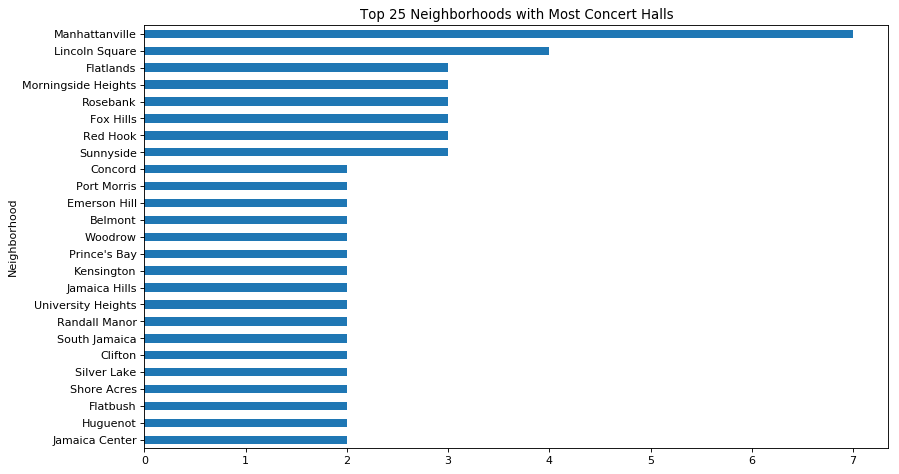

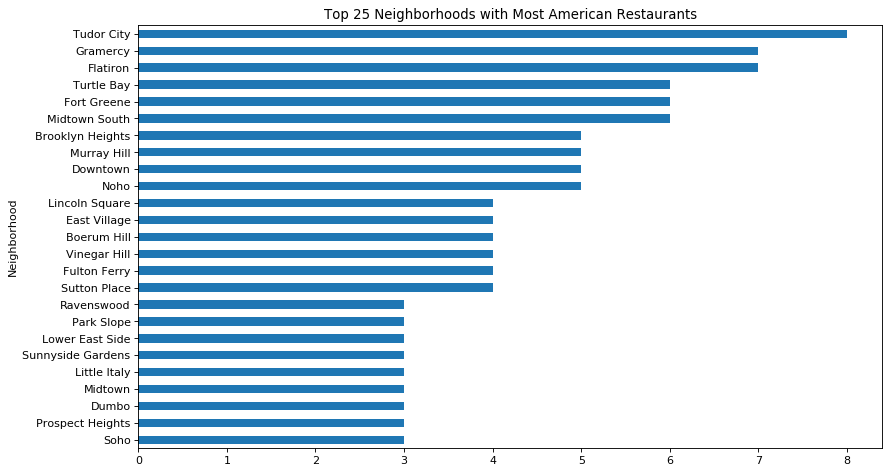

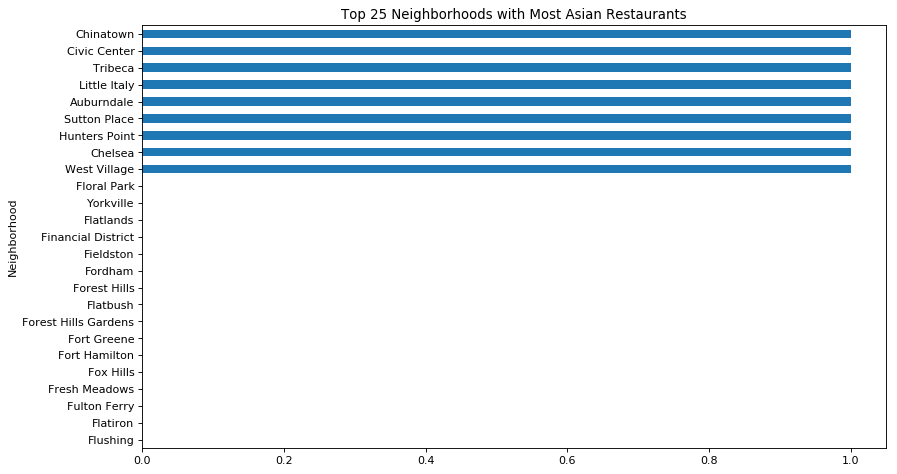

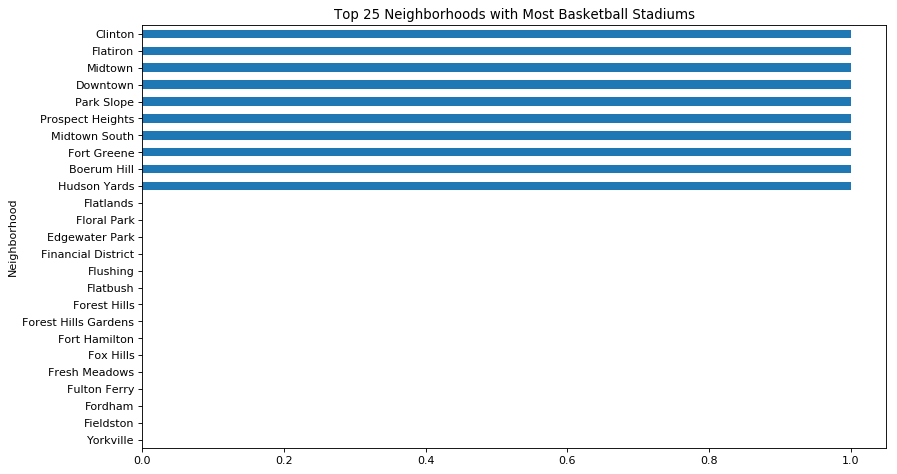

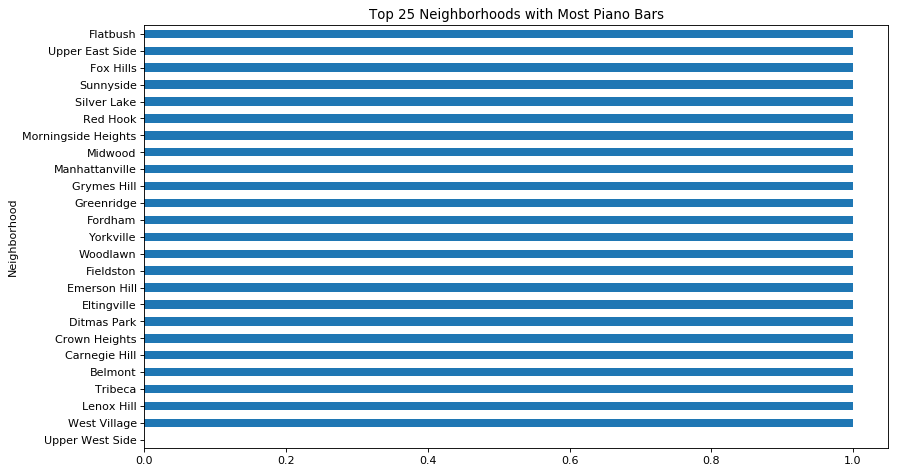

In [44]:
plot_categories = ['Concert Hall', 'American Restaurant', 'Asian Restaurant', 'Basketball Stadium', 'Piano Bar']
n = 25
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Top {n} Neighborhoods with Most {category}s')
    top_category_neighborhoods = venue_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods = top_category_neighborhoods.sort_values(ascending=True)
    top_category_neighborhoods.plot.barh(y=category, rot=0)

#### Determine the total amount of venues of each category

In [47]:
venue_totals = {}
for category in categories:
    venue_totals[category] = venue_counts[category].sum()

venue_totals

{'Music Venue': 468,
 'Other Nightlife': 475,
 'Bar': 2091,
 'Smoke Shop': 13,
 'Nightclub': 480,
 'Nightlife Spot': 118,
 'Speakeasy': 130,
 'Hookah Bar': 243,
 'Pub': 341,
 'Lounge': 928,
 'Jazz Club': 50,
 'Sports Bar': 264,
 'Recording Studio': 82,
 'Cocktail Bar': 500,
 'Beach Bar': 16,
 'Record Shop': 112,
 'Piano Bar': 24,
 'Beer Garden': 214,
 'Hotel Bar': 114,
 'Dive Bar': 200,
 'Latin American Restaurant': 26,
 'Beer Bar': 74,
 'American Restaurant': 206,
 'Strip Club': 85,
 'Coffee Shop': 28,
 'Café': 58,
 'Whisky Bar': 37,
 'Wine Bar': 278,
 'Concert Hall': 133,
 'Arcade': 3,
 'Market': 1,
 'Brewery': 119,
 'Irish Pub': 14,
 'Caribbean Restaurant': 30,
 'Karaoke Bar': 171,
 'Liquor Store': 6,
 'Seafood Restaurant': 37,
 'Theater': 19,
 'Music Store': 122,
 'Restaurant': 37,
 'Tapas Restaurant': 18,
 'Italian Restaurant': 91,
 'Rock Club': 99,
 'Fast Food Restaurant': 3,
 'Bookstore': 1,
 'Distillery': 2,
 'Gay Bar': 100,
 'Indie Theater': 6,
 'Mexican Restaurant': 58,
 'Din

#### For each venue category, determine the percentage of entities in each neighborhood

In [48]:
venue_mean = pd.DataFrame()
for category, total in venue_totals.items():
    venue_mean[category] = venue_counts[category].apply(lambda x: x / total)
venue_mean = venue_mean.reindex(sorted(venue_mean.columns), axis=1).reset_index()
venue_mean.head(5)

,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Brewery,Building,Burger Joint,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Cocktail Bar,Coffee Shop,College Residence Hall,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Coworking Space,Cuban Restaurant,Dance Studio,Diner,Distillery,Dive Bar,English Restaurant,Event Space,Fast Food Restaurant,Field,Food Court,Fraternity House,French Restaurant,Fried Chicken Joint,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gourmet Shop,Gym,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Museum,Music Festival,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Office,Opera House,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Pet Café,Piano Bar,Pizza Place,Pool Hall,Portuguese Restaurant,Professional & Other Places,Pub,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Skating Rink,Smoke Shop,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Street Food Gathering,Strip Club,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tech Startup,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003348,0.0,0.0,0.0,0.0,0.004673,0.0,0.0,0.0,0.0,0.0,0.0,0.008403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.004115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.003233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00641,0.0,0.0,0.0,0.006250,0.000000,0.0,0.0,0.0,0.002105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003788,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000956,0.0,0.0,0.0,0.0,0.004673,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.002105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002933,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003788,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003597,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001435,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004,0.0,0.0,0.0,0.0,0.0,0.007519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.004115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.

#### Creating a dataframe that shows the top 5 venue categories each neighborhood is known for

In [49]:
def return_top_venue_categories(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Top Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Top Venue Category'.format(ind+1))

neighborhoods_top_venue_categories = pd.DataFrame(columns=columns)
neighborhoods_top_venue_categories['Neighborhood'] = venue_mean['Neighborhood']

for ind in np.arange(venue_mean.shape[0]):
    neighborhoods_top_venue_categories.iloc[ind, 1:] = return_top_venue_categories(venue_mean.iloc[ind, :], num_top_venues)

neighborhoods_top_venue_categories.head(5)

,Neighborhood,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Allerton,Liquor Store,Brewery,Music Venue,Nightclub,Beer Garden
1,Annadale,Beer Garden,Sports Bar,Wine Bar,Pub,Other Nightlife
2,Arden Heights,Concert Hall,Pub,Hookah Bar,Cocktail Bar,Sports Bar
3,Arlington,Nightlife Spot,Gay Bar,Brewery,Sports Bar,Bar
4,Arrochar,Steakhouse,Record Shop,Nightlife Spot,Other Nightlife,Nightclub


### Create a KMeans Model To Cluster Neighborhoods

In [51]:
kclusters = 15

venue_grouped_clustering = venue_mean.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

kmeans.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0, 14,  0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0, 10,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  8,  0

#### Creating a new dataframe merging neighborhood location data, top venue category by neighborhood, and cluster labels

In [52]:
neighborhoods_top_venue_categories.insert(1,'Cluster Labels', kmeans.labels_)

ny_neighborhood_music_profile = nyc_neighborhoods.drop(columns=['Borough'])

ny_neighborhood_music_profile = ny_neighborhood_music_profile.join(neighborhoods_top_venue_categories.set_index('Neighborhood'), on='Neighborhood').dropna(axis=0)

ny_neighborhood_music_profile.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Wakefield,40.894705,-73.847201,0.0,Smoke Shop,Music Venue,Nightlife Spot,Speakeasy,Other Nightlife
1,Co-op City,40.874294,-73.829939,0.0,Jazz Club,Recording Studio,Sports Bar,Nightclub,Pub
2,Eastchester,40.887556,-73.827806,0.0,Recording Studio,Jazz Club,Sports Bar,Nightclub,Cocktail Bar
3,Fieldston,40.895437,-73.905643,0.0,Piano Bar,Nightlife Spot,Sports Bar,Record Shop,Pub
4,Riverdale,40.890834,-73.912585,0.0,Nightlife Spot,Speakeasy,Music Venue,Hotel Bar,Sports Bar


#### Creating A Visualization of The Clusters

In [53]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 40.730610
longitude = -73.935242
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.45)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_neighborhood_music_profile['Latitude'], ny_neighborhood_music_profile['Longitude'], ny_neighborhood_music_profile['Neighborhood'], ny_neighborhood_music_profile['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining Clusters

In [54]:
for cluster in range(0, kclusters):
    print(f'Cluster {cluster}:')
    print(ny_neighborhood_music_profile.loc[ny_neighborhood_music_profile['Cluster Labels'] == cluster, ny_neighborhood_music_profile.columns[[0] + list(range(4, ny_neighborhood_music_profile.shape[1]))]], end="\n\n\n")

Cluster 0:
                  Neighborhood                    1st Top Venue Category  \
0                    Wakefield                                Smoke Shop   
1                   Co-op City                                 Jazz Club   
2                  Eastchester                          Recording Studio   
3                    Fieldston                                 Piano Bar   
4                    Riverdale                            Nightlife Spot   
5                  Kingsbridge                 Latin American Restaurant   
6                  Marble Hill                 Latin American Restaurant   
7                     Woodlawn                                    Market   
8                      Norwood                      Caribbean Restaurant   
9               Williamsbridge                                 Nightclub   
10                  Baychester                      Caribbean Restaurant   
11              Pelham Parkway                              Liquor Store   
1